In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_precision
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, Precision, Recall, F1Score


In [48]:
selected_classes = [3, 4, 7]
pickle_dir = 'pickles'
pytorch_chkpt_dir = 'pt-saves'
pretrained_model_path = f"{pytorch_chkpt_dir}/mnist_pt.pth"

In [49]:
# create folder if not exists
os.makedirs(pickle_dir, exist_ok=True)
os.makedirs(pytorch_chkpt_dir, exist_ok=True)

In [50]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

In [ ]:
# def train_model(model, train_loader, num_epochs=20, fine_tuning=False):
#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     # Set the model to training mode
#     model.train()
#     # Training loop
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         # Create a progress bar for the current epoch
#         with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
#             for inputs, labels in train_loader:
#                 # Zero the gradients
#                 optimizer.zero_grad()
#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 # Backward pass and optimization
#                 loss.backward()
#                 optimizer.step()
#                 # Track the running loss
#                 running_loss += loss.item()
#                 # Update the progress bar
#                 pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
#                 pbar.update(1)
#     if fine_tuning:
#         print("Fine-tuning complete!")
#     else:
#         print("Training complete!")

In [51]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs=20, fine_tuning=False):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize lists to track metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Set the model to training mode
        model.train()
        
        # Create a progress bar for the current epoch
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in train_loader:
                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                # Track the running loss
                running_loss += loss.item()
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                # Update the progress bar
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    if fine_tuning:
        print("Fine-tuning complete!")
    else:
        print("Training complete!")

    # Plot the metrics
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [52]:
def load_from_pickle(pickle_name):
    pickled_data = pickle.load(open(f"{pickle_dir}/{pickle_name}", "rb"))
    return DataLoader(pickled_data, batch_size=32, shuffle=True)

In [53]:
def load_pretrained_model():
    model_pt = SimpleNN()
    mnist_pt = torch.load(pretrained_model_path)
    model_pt.load_state_dict(mnist_pt)
    return model_pt

In [54]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to track the predictions and true labels
    all_predictions = []
    all_labels = []
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass: Get model predictions
            outputs = model(inputs)
            
            # Get the predicted class by finding the class with the highest score
            _, predicted = torch.max(outputs, 1)
            
            # Store the predictions and true labels for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    cr = classification_report(all_labels, all_predictions)
    print(f'Classification report for tain data:\n{cr}')

    # Confusion Matrix
    # conf_matrix = confusion_matrix(all_labels, all_predictions)

In [55]:
def plot_mnist_data(loader):
    images, labels = next(iter(loader))
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    # Display the images in a grid
    plt.figure(figsize=(4, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

## Part 1: Split Data

In [56]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [57]:
# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

In [58]:
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

In [59]:
selected = {}
remaining = []
for i in mnist_train:
    if i[1] in selected_classes:
        if i[1] not in selected:
            selected[i[1]] = []
        if len(selected[i[1]]) < 1000:
            selected[i[1]].append(i)
        else:
            remaining.append(i)
    else:
        remaining.append(i)

for sc in selected:
    print(f"Class {sc} has {len(selected[sc])} samples")
    # write training datasets for fine-tuning to pickles
    pickle.dump(selected[sc], open(f"{pickle_dir}/train_{sc}.pkl", "wb"))
# write remaining dataset to separate pickle as well
print(f"Remaining list has {len(remaining)} samples")
pickle.dump(remaining, open(f"{pickle_dir}/train_rem.pkl", "wb"))

Class 4 has 1000 samples
Class 3 has 1000 samples
Class 7 has 1000 samples
Remaining list has 57000 samples


## Part 2: Train Model as Pretrained and Computation of its Functional Metrics

In [60]:
# load the data from pickle
train_loader = load_from_pickle("train_rem.pkl")
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

Epoch [1/50]: 100%|██████████| 1782/1782 [00:07<00:00, 247.42batch/s, Loss=0.3458]


Epoch [1/50] - Train Loss: 0.3458, Train Acc: 0.8947, Test Loss: 0.1862, Test Acc: 0.9437


Epoch [2/50]: 100%|██████████| 1782/1782 [00:07<00:00, 233.86batch/s, Loss=0.1639]


Epoch [2/50] - Train Loss: 0.1639, Train Acc: 0.9497, Test Loss: 0.1660, Test Acc: 0.9474


Epoch [3/50]: 100%|██████████| 1782/1782 [00:07<00:00, 237.25batch/s, Loss=0.1244]


Epoch [3/50] - Train Loss: 0.1244, Train Acc: 0.9616, Test Loss: 0.1171, Test Acc: 0.9643


Epoch [4/50]: 100%|██████████| 1782/1782 [00:07<00:00, 238.77batch/s, Loss=0.1055]


Epoch [4/50] - Train Loss: 0.1055, Train Acc: 0.9662, Test Loss: 0.1145, Test Acc: 0.9638


Epoch [5/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.51batch/s, Loss=0.0893]


Epoch [5/50] - Train Loss: 0.0893, Train Acc: 0.9722, Test Loss: 0.1317, Test Acc: 0.9612


Epoch [6/50]: 100%|██████████| 1782/1782 [00:07<00:00, 224.74batch/s, Loss=0.0800]


Epoch [6/50] - Train Loss: 0.0800, Train Acc: 0.9744, Test Loss: 0.1393, Test Acc: 0.9585


Epoch [7/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.71batch/s, Loss=0.0724]


Epoch [7/50] - Train Loss: 0.0724, Train Acc: 0.9772, Test Loss: 0.0914, Test Acc: 0.9713


Epoch [8/50]: 100%|██████████| 1782/1782 [00:07<00:00, 234.62batch/s, Loss=0.0643]


Epoch [8/50] - Train Loss: 0.0643, Train Acc: 0.9789, Test Loss: 0.1009, Test Acc: 0.9708


Epoch [9/50]: 100%|██████████| 1782/1782 [00:07<00:00, 226.75batch/s, Loss=0.0607]


Epoch [9/50] - Train Loss: 0.0607, Train Acc: 0.9803, Test Loss: 0.1098, Test Acc: 0.9673


Epoch [10/50]: 100%|██████████| 1782/1782 [00:08<00:00, 222.49batch/s, Loss=0.0555]


Epoch [10/50] - Train Loss: 0.0555, Train Acc: 0.9826, Test Loss: 0.1097, Test Acc: 0.9691


Epoch [11/50]: 100%|██████████| 1782/1782 [00:07<00:00, 230.50batch/s, Loss=0.0508]


Epoch [11/50] - Train Loss: 0.0508, Train Acc: 0.9832, Test Loss: 0.1147, Test Acc: 0.9699


Epoch [12/50]: 100%|██████████| 1782/1782 [00:07<00:00, 227.46batch/s, Loss=0.0486]


Epoch [12/50] - Train Loss: 0.0486, Train Acc: 0.9838, Test Loss: 0.1120, Test Acc: 0.9704


Epoch [13/50]: 100%|██████████| 1782/1782 [00:07<00:00, 230.46batch/s, Loss=0.0466]


Epoch [13/50] - Train Loss: 0.0466, Train Acc: 0.9846, Test Loss: 0.1093, Test Acc: 0.9714


Epoch [14/50]: 100%|██████████| 1782/1782 [00:08<00:00, 220.47batch/s, Loss=0.0435]


Epoch [14/50] - Train Loss: 0.0435, Train Acc: 0.9861, Test Loss: 0.0909, Test Acc: 0.9749


Epoch [15/50]: 100%|██████████| 1782/1782 [00:08<00:00, 217.75batch/s, Loss=0.0414]


Epoch [15/50] - Train Loss: 0.0414, Train Acc: 0.9862, Test Loss: 0.1063, Test Acc: 0.9739


Epoch [16/50]: 100%|██████████| 1782/1782 [00:07<00:00, 239.11batch/s, Loss=0.0375]


Epoch [16/50] - Train Loss: 0.0375, Train Acc: 0.9873, Test Loss: 0.1180, Test Acc: 0.9708


Epoch [17/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.88batch/s, Loss=0.0380]


Epoch [17/50] - Train Loss: 0.0380, Train Acc: 0.9874, Test Loss: 0.1001, Test Acc: 0.9724


Epoch [18/50]: 100%|██████████| 1782/1782 [00:07<00:00, 227.80batch/s, Loss=0.0345]


Epoch [18/50] - Train Loss: 0.0345, Train Acc: 0.9886, Test Loss: 0.1131, Test Acc: 0.9750


Epoch [19/50]: 100%|██████████| 1782/1782 [00:07<00:00, 237.73batch/s, Loss=0.0348]


Epoch [19/50] - Train Loss: 0.0348, Train Acc: 0.9882, Test Loss: 0.1200, Test Acc: 0.9711


Epoch [20/50]: 100%|██████████| 1782/1782 [00:07<00:00, 241.57batch/s, Loss=0.0328]


Epoch [20/50] - Train Loss: 0.0328, Train Acc: 0.9888, Test Loss: 0.1027, Test Acc: 0.9755


Epoch [21/50]: 100%|██████████| 1782/1782 [00:07<00:00, 241.18batch/s, Loss=0.0309]


Epoch [21/50] - Train Loss: 0.0309, Train Acc: 0.9897, Test Loss: 0.1136, Test Acc: 0.9745


Epoch [22/50]: 100%|██████████| 1782/1782 [00:08<00:00, 219.58batch/s, Loss=0.0298]


Epoch [22/50] - Train Loss: 0.0298, Train Acc: 0.9900, Test Loss: 0.1051, Test Acc: 0.9765


Epoch [23/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.81batch/s, Loss=0.0271]


Epoch [23/50] - Train Loss: 0.0271, Train Acc: 0.9908, Test Loss: 0.1383, Test Acc: 0.9724


Epoch [24/50]: 100%|██████████| 1782/1782 [00:07<00:00, 239.00batch/s, Loss=0.0290]


Epoch [24/50] - Train Loss: 0.0290, Train Acc: 0.9905, Test Loss: 0.1482, Test Acc: 0.9708


Epoch [25/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.72batch/s, Loss=0.0280]


Epoch [25/50] - Train Loss: 0.0280, Train Acc: 0.9906, Test Loss: 0.1346, Test Acc: 0.9744


Epoch [26/50]: 100%|██████████| 1782/1782 [00:07<00:00, 236.87batch/s, Loss=0.0273]


Epoch [26/50] - Train Loss: 0.0273, Train Acc: 0.9908, Test Loss: 0.1448, Test Acc: 0.9734


Epoch [27/50]: 100%|██████████| 1782/1782 [00:07<00:00, 240.09batch/s, Loss=0.0257]


Epoch [27/50] - Train Loss: 0.0257, Train Acc: 0.9916, Test Loss: 0.1695, Test Acc: 0.9706


Epoch [28/50]: 100%|██████████| 1782/1782 [00:07<00:00, 231.61batch/s, Loss=0.0279]


Epoch [28/50] - Train Loss: 0.0279, Train Acc: 0.9910, Test Loss: 0.1394, Test Acc: 0.9753


Epoch [29/50]: 100%|██████████| 1782/1782 [00:08<00:00, 220.94batch/s, Loss=0.0249]


Epoch [29/50] - Train Loss: 0.0249, Train Acc: 0.9920, Test Loss: 0.1386, Test Acc: 0.9742


Epoch [30/50]: 100%|██████████| 1782/1782 [00:08<00:00, 218.85batch/s, Loss=0.0249]


Epoch [30/50] - Train Loss: 0.0249, Train Acc: 0.9919, Test Loss: 0.1624, Test Acc: 0.9714


Epoch [31/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.16batch/s, Loss=0.0242]


Epoch [31/50] - Train Loss: 0.0242, Train Acc: 0.9923, Test Loss: 0.1261, Test Acc: 0.9764


Epoch [32/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.91batch/s, Loss=0.0224]


Epoch [32/50] - Train Loss: 0.0224, Train Acc: 0.9925, Test Loss: 0.1470, Test Acc: 0.9751


Epoch [33/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.00batch/s, Loss=0.0226]


Epoch [33/50] - Train Loss: 0.0226, Train Acc: 0.9924, Test Loss: 0.1431, Test Acc: 0.9775


Epoch [34/50]: 100%|██████████| 1782/1782 [00:07<00:00, 235.81batch/s, Loss=0.0233]


Epoch [34/50] - Train Loss: 0.0233, Train Acc: 0.9927, Test Loss: 0.1498, Test Acc: 0.9736


Epoch [35/50]: 100%|██████████| 1782/1782 [00:07<00:00, 226.82batch/s, Loss=0.0253]


Epoch [35/50] - Train Loss: 0.0253, Train Acc: 0.9921, Test Loss: 0.1533, Test Acc: 0.9754


Epoch [36/50]: 100%|██████████| 1782/1782 [00:07<00:00, 234.13batch/s, Loss=0.0174]


Epoch [36/50] - Train Loss: 0.0174, Train Acc: 0.9943, Test Loss: 0.1451, Test Acc: 0.9759


Epoch [37/50]: 100%|██████████| 1782/1782 [00:07<00:00, 228.41batch/s, Loss=0.0235]


Epoch [37/50] - Train Loss: 0.0235, Train Acc: 0.9929, Test Loss: 0.1566, Test Acc: 0.9770


Epoch [38/50]: 100%|██████████| 1782/1782 [00:07<00:00, 227.51batch/s, Loss=0.0228]


Epoch [38/50] - Train Loss: 0.0228, Train Acc: 0.9926, Test Loss: 0.1329, Test Acc: 0.9784


Epoch [39/50]: 100%|██████████| 1782/1782 [00:07<00:00, 232.36batch/s, Loss=0.0185]


Epoch [39/50] - Train Loss: 0.0185, Train Acc: 0.9941, Test Loss: 0.1576, Test Acc: 0.9729


Epoch [40/50]: 100%|██████████| 1782/1782 [00:08<00:00, 221.33batch/s, Loss=0.0236]


Epoch [40/50] - Train Loss: 0.0236, Train Acc: 0.9920, Test Loss: 0.1575, Test Acc: 0.9729


Epoch [41/50]: 100%|██████████| 1782/1782 [00:08<00:00, 221.23batch/s, Loss=0.0195]


Epoch [41/50] - Train Loss: 0.0195, Train Acc: 0.9942, Test Loss: 0.2097, Test Acc: 0.9710


Epoch [42/50]: 100%|██████████| 1782/1782 [00:08<00:00, 219.69batch/s, Loss=0.0222]


Epoch [42/50] - Train Loss: 0.0222, Train Acc: 0.9934, Test Loss: 0.1790, Test Acc: 0.9762


Epoch [43/50]: 100%|██████████| 1782/1782 [00:08<00:00, 212.40batch/s, Loss=0.0234]


Epoch [43/50] - Train Loss: 0.0234, Train Acc: 0.9933, Test Loss: 0.1568, Test Acc: 0.9763


Epoch [44/50]: 100%|██████████| 1782/1782 [00:08<00:00, 222.07batch/s, Loss=0.0172]


Epoch [44/50] - Train Loss: 0.0172, Train Acc: 0.9944, Test Loss: 0.1644, Test Acc: 0.9746


Epoch [45/50]: 100%|██████████| 1782/1782 [00:07<00:00, 224.87batch/s, Loss=0.0203]


Epoch [45/50] - Train Loss: 0.0203, Train Acc: 0.9932, Test Loss: 0.1683, Test Acc: 0.9768


Epoch [46/50]: 100%|██████████| 1782/1782 [00:08<00:00, 200.08batch/s, Loss=0.0200]


Epoch [46/50] - Train Loss: 0.0200, Train Acc: 0.9939, Test Loss: 0.1774, Test Acc: 0.9737


Epoch [47/50]: 100%|██████████| 1782/1782 [00:08<00:00, 201.17batch/s, Loss=0.0204]


Epoch [47/50] - Train Loss: 0.0204, Train Acc: 0.9937, Test Loss: 0.1537, Test Acc: 0.9775


Epoch [48/50]: 100%|██████████| 1782/1782 [00:08<00:00, 217.84batch/s, Loss=0.0202]


Epoch [48/50] - Train Loss: 0.0202, Train Acc: 0.9942, Test Loss: 0.2037, Test Acc: 0.9724


Epoch [49/50]: 100%|██████████| 1782/1782 [00:08<00:00, 218.74batch/s, Loss=0.0181]


Epoch [49/50] - Train Loss: 0.0181, Train Acc: 0.9945, Test Loss: 0.1939, Test Acc: 0.9759


Epoch [50/50]: 100%|██████████| 1782/1782 [00:08<00:00, 214.02batch/s, Loss=0.0180]


Epoch [50/50] - Train Loss: 0.0180, Train Acc: 0.9946, Test Loss: 0.2459, Test Acc: 0.9649
Fine-tuning complete!


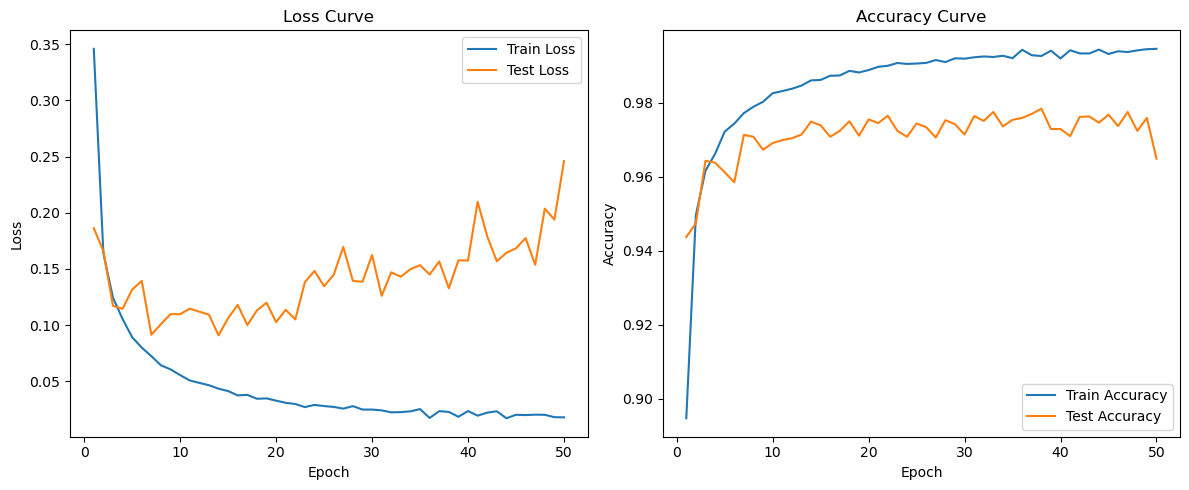

In [63]:
# Initialize the model
model = SimpleNN()
train_model(model, test_loader=test_loader, train_loader=train_loader, num_epochs=50, fine_tuning=True)

In [64]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.97      0.98      1135
           2       0.99      0.95      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.89      0.94       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.93      0.98      0.95       974
           9       0.88      0.98      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.97     10000



In [65]:
# load the data from pickle
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")
# Initialize the model
# model_ft_3 = load_pretrained_model()

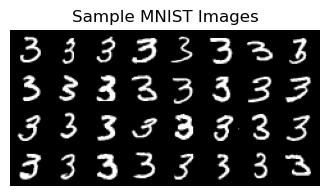

In [66]:
plot_mnist_data(train_loader_3)

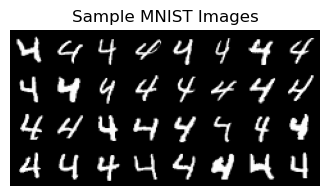

In [67]:
plot_mnist_data(train_loader_4)

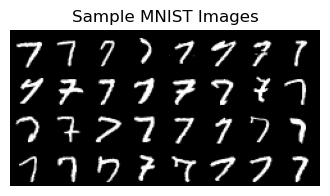

In [68]:
plot_mnist_data(train_loader_7)

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 182.30batch/s, Loss=0.0882]


Epoch [1/5] - Train Loss: 0.0882, Train Acc: 0.9920, Test Loss: 3.2294, Test Acc: 0.7012


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 274.70batch/s, Loss=0.0074]


Epoch [2/5] - Train Loss: 0.0074, Train Acc: 0.9990, Test Loss: 5.1383, Test Acc: 0.5938


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 262.71batch/s, Loss=0.0011]


Epoch [3/5] - Train Loss: 0.0011, Train Acc: 0.9990, Test Loss: 5.2081, Test Acc: 0.5899


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 230.60batch/s, Loss=0.0001]


Epoch [4/5] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 5.1995, Test Acc: 0.5904


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 157.86batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 5.2077, Test Acc: 0.5904
Fine-tuning complete!


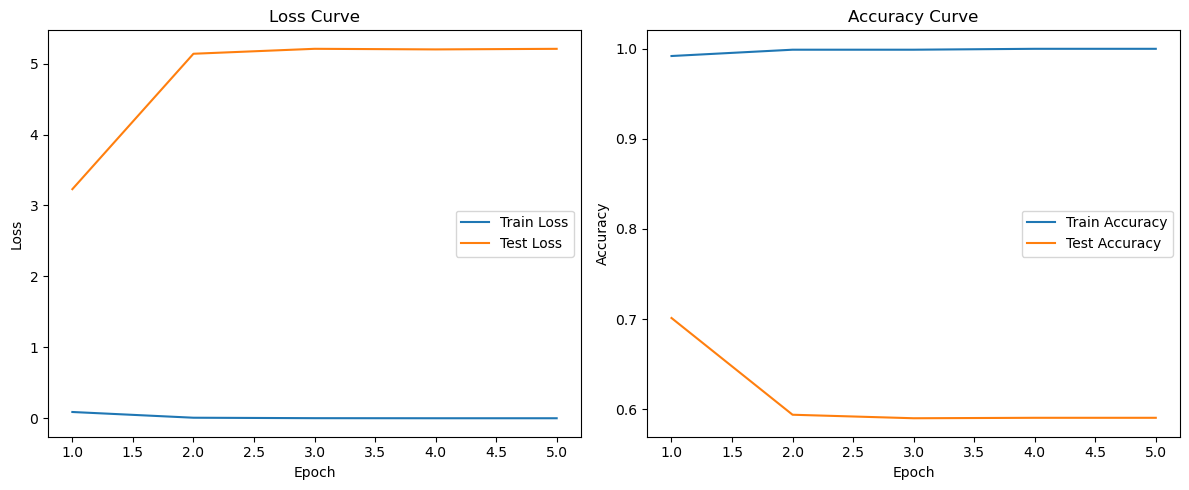

In [70]:
train_model(model, train_loader_3, test_loader=test_loader,num_epochs=5, fine_tuning=True)

In [71]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       980
           1       1.00      0.55      0.71      1135
           2       0.95      0.51      0.67      1032
           3       0.21      1.00      0.35      1010
           4       0.99      0.70      0.82       982
           5       0.93      0.52      0.67       892
           6       0.99      0.75      0.86       958
           7       0.92      0.28      0.43      1028
           8       0.91      0.42      0.58       974
           9       0.65      0.28      0.39      1009

    accuracy                           0.59     10000
   macro avg       0.85      0.59      0.64     10000
weighted avg       0.85      0.59      0.64     10000



Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 198.66batch/s, Loss=0.2119]


Epoch [1/5] - Train Loss: 0.2119, Train Acc: 0.9670, Test Loss: 0.9765, Test Acc: 0.8682


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 171.93batch/s, Loss=0.0000]


Epoch [2/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2167, Test Acc: 0.8468


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 165.59batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.1918, Test Acc: 0.8451


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 258.15batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.2031, Test Acc: 0.8448


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 164.69batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.1852, Test Acc: 0.8448
Fine-tuning complete!


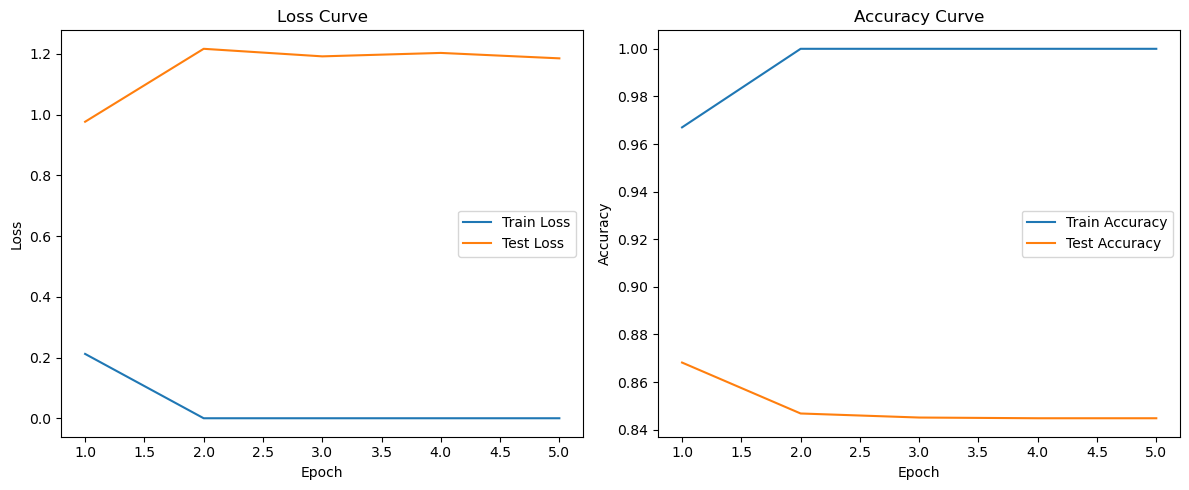

In [73]:
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=5, fine_tuning=True )

In [74]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       980
           1       0.95      0.96      0.95      1135
           2       1.00      0.72      0.84      1032
           3       0.75      0.98      0.85      1010
           4       0.49      1.00      0.66       982
           5       0.98      0.86      0.91       892
           6       0.99      0.85      0.91       958
           7       0.96      0.83      0.89      1028
           8       0.94      0.87      0.90       974
           9       0.94      0.42      0.58      1009

    accuracy                           0.84     10000
   macro avg       0.90      0.84      0.85     10000
weighted avg       0.90      0.84      0.85     10000



Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 180.12batch/s, Loss=0.1183]


Epoch [1/5] - Train Loss: 0.1183, Train Acc: 0.9830, Test Loss: 0.7847, Test Acc: 0.8908


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 175.25batch/s, Loss=0.0041]


Epoch [2/5] - Train Loss: 0.0041, Train Acc: 0.9990, Test Loss: 1.0428, Test Acc: 0.8633


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 304.28batch/s, Loss=0.0001]


Epoch [3/5] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 1.0813, Test Acc: 0.8561


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 304.90batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.0877, Test Acc: 0.8541


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 285.52batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.1083, Test Acc: 0.8533
Fine-tuning complete!


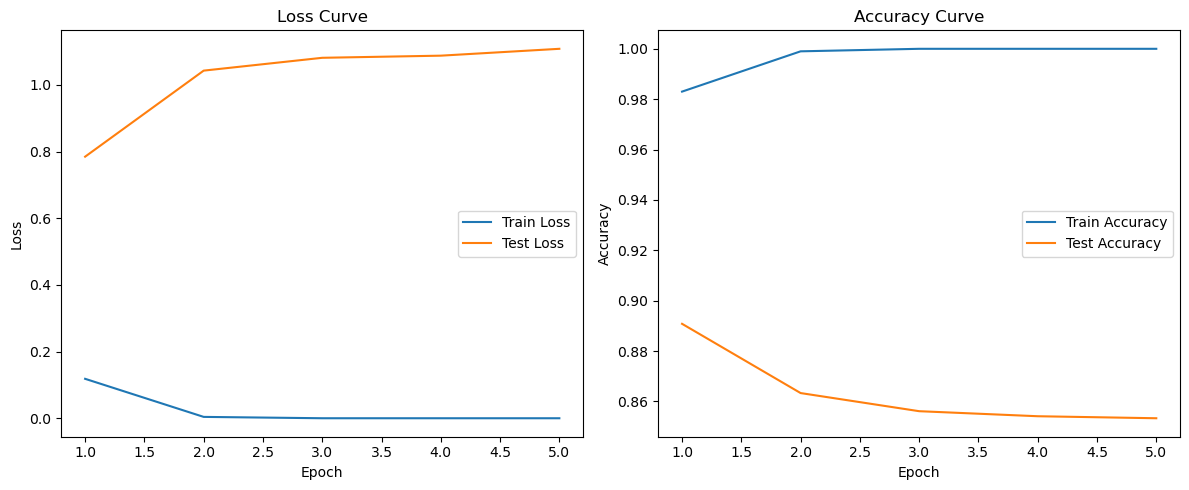

In [75]:
train_model(model, train_loader_7, test_loader=test_loader,num_epochs=5, fine_tuning=True)

In [76]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       980
           1       0.99      0.89      0.93      1135
           2       0.98      0.77      0.86      1032
           3       0.76      0.98      0.85      1010
           4       0.87      0.91      0.89       982
           5       0.96      0.83      0.89       892
           6       0.99      0.81      0.89       958
           7       0.53      1.00      0.69      1028
           8       1.00      0.80      0.89       974
           9       1.00      0.60      0.75      1009

    accuracy                           0.85     10000
   macro avg       0.91      0.85      0.86     10000
weighted avg       0.90      0.85      0.86     10000



In [77]:
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 183.86batch/s, Loss=0.0383]


Epoch [1/5] - Train Loss: 0.0383, Train Acc: 0.9940, Test Loss: 2.2067, Test Acc: 0.7683


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 173.40batch/s, Loss=0.0001]


Epoch [2/5] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 3.0823, Test Acc: 0.6992


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 174.62batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1303, Test Acc: 0.6949


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 168.37batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1689, Test Acc: 0.6945


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 253.89batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1815, Test Acc: 0.6939
Fine-tuning complete!


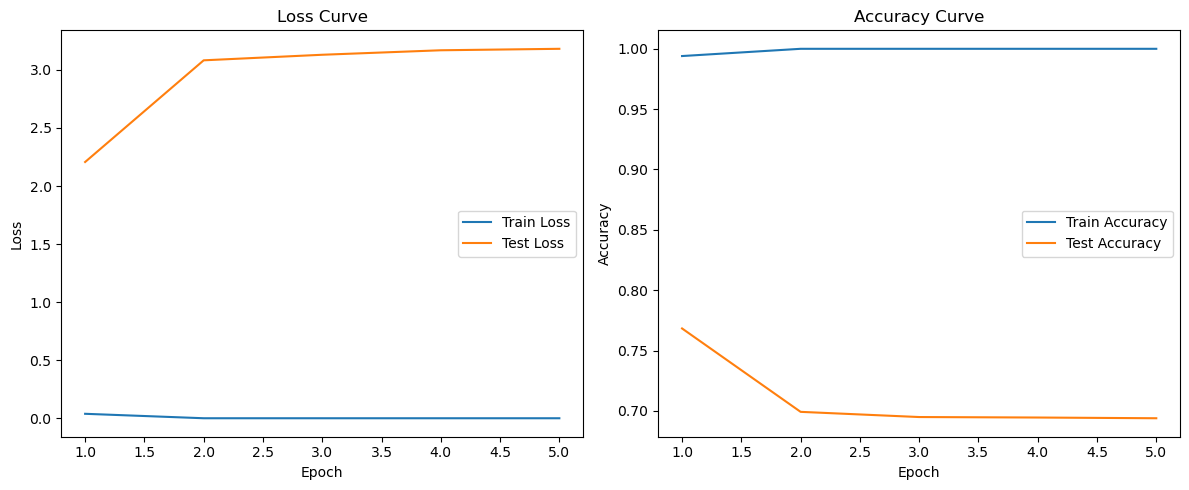

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 271.73batch/s, Loss=0.0241]


Epoch [1/5] - Train Loss: 0.0241, Train Acc: 0.9900, Test Loss: 2.2096, Test Acc: 0.7378


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 286.41batch/s, Loss=0.0000]


Epoch [2/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.3187, Test Acc: 0.7248


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 268.68batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.3250, Test Acc: 0.7238


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 169.43batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.3068, Test Acc: 0.7223


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 217.55batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.3177, Test Acc: 0.7209
Fine-tuning complete!


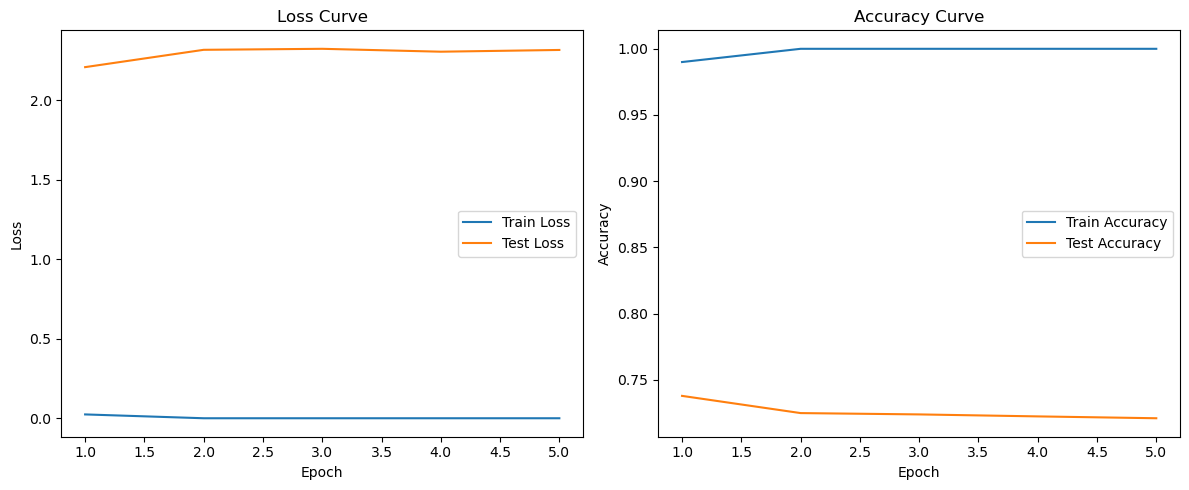

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 276.04batch/s, Loss=0.1884]


Epoch [1/5] - Train Loss: 0.1884, Train Acc: 0.9680, Test Loss: 1.9658, Test Acc: 0.7484


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 295.20batch/s, Loss=0.0000]


Epoch [2/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.1505, Test Acc: 0.7267


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 155.67batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2079, Test Acc: 0.7245


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 134.01batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2067, Test Acc: 0.7241


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 235.34batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2166, Test Acc: 0.7235
Fine-tuning complete!


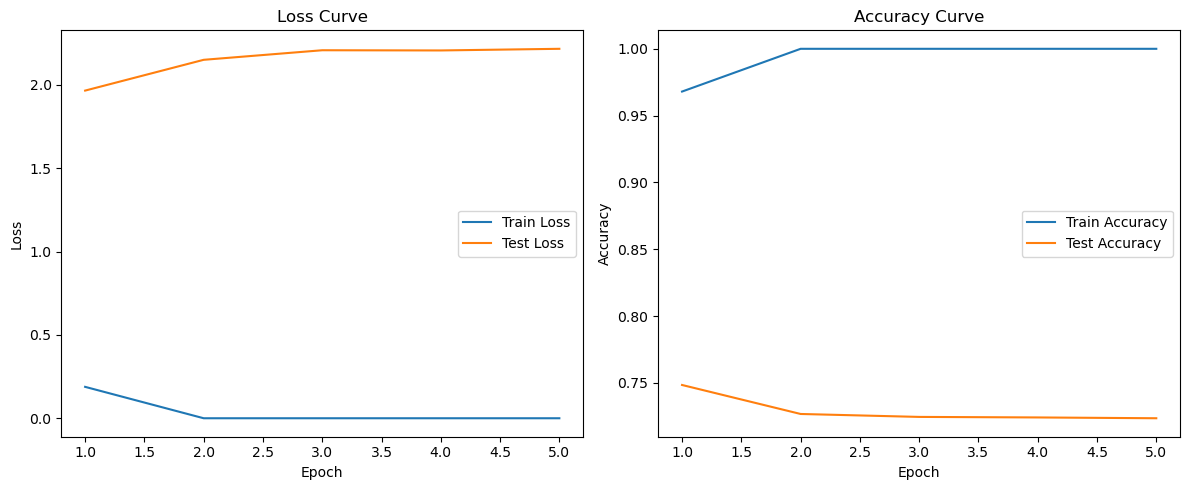

In [79]:
train_model(model, train_loader_3, test_loader=test_loader, num_epochs=5, fine_tuning=True)
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=5, fine_tuning=True)
train_model(model, train_loader_7, test_loader=test_loader, num_epochs=5, fine_tuning=True)


In [80]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       980
           1       0.98      0.58      0.73      1135
           2       0.99      0.60      0.75      1032
           3       0.63      0.97      0.77      1010
           4       0.69      0.94      0.80       982
           5       0.98      0.63      0.77       892
           6       0.99      0.72      0.83       958
           7       0.37      1.00      0.54      1028
           8       1.00      0.66      0.79       974
           9       0.99      0.26      0.42      1009

    accuracy                           0.72     10000
   macro avg       0.86      0.72      0.73     10000
weighted avg       0.86      0.72      0.73     10000



In [28]:
# Save the model
torch.save(model.state_dict(), pretrained_model_path)
print("Model saved successfully!")

Model saved successfully!
